In [1]:
import torch
from torch.nn import MSELoss

from uniphm.data import Dataset
from uniphm.data.loader.XJTULoader import XJTULoader
from uniphm.data.labeler.BearingRulLabeler import BearingRulLabeler
from uniphm.data.process.EntityPipeline import EntityPipeline
from uniphm.data.process.array.RMSProcessor import RMSProcessor
from uniphm.engine.metric.PHM2008Score import PHM2008Score
from uniphm.engine.metric.PHM2012Score import PHM2012Score
from uniphm.engine.metric.PercentError import PercentError
from uniphm.engine.metric.MAE import MAE
from uniphm.engine.metric.MSE import MSE
from uniphm.engine.metric.RMSE import RMSE
from uniphm.data.process.entity.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from uniphm.engine.tester.BaseTester import BaseTester
from uniphm.engine.trainer.BaseTrainer import BaseTrainer
from uniphm.model.basic.CNN import CNN
from uniphm.engine.Evaluator import Evaluator
from uniphm.engine.callback.CheckGradientsCallback import CheckGradientsCallback
from uniphm.engine.callback.EarlyStoppingCallback import EarlyStoppingCallback
from uniphm.engine.callback.TensorBoardCallback import TensorBoardCallback
from uniphm.util.Cache import Cache
from uniphm.util.Plotter import Plotter

In [2]:
cache_dataset = True
# cache_dataset = False
# cache_model = True
cache_model = False

Plotter.DPI = 50
Plotter.SIZE = (10, 6)

# 获取数据集

In [3]:
dataset = Cache.load('prognosis_bearing_dataset', is_able=cache_dataset)
if dataset is None:
    data_loader = XJTULoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
    labeler = BearingRulLabeler(2048, is_from_fpt=False, is_rectified=True)

    pipeline = EntityPipeline()
    pipeline.register(
        processor=RMSProcessor(data_loader['continuum']),
        input_key='Horizontal Vibration',
        output_key='H_RMS'
    )
    pipeline.register(
        processor=ThreeSigmaFPTCalculator(),
        input_key='H_RMS',
    )

    dataset = Dataset()
    for bearing_name in ['Bearing1_1', 'Bearing1_2', 'Bearing1_3',
                         'Bearing2_1', 'Bearing2_2',
                         'Bearing3_1', 'Bearing3_2']:
        bearing = data_loader(bearing_name, 'Horizontal Vibration')
        pipeline.execute(bearing)
        dataset.append_entity(labeler(bearing, key='Horizontal Vibration'))
    Cache.save(dataset, 'prognosis_bearing_dataset')

[DEBUG   17:26:20]  [Cache]  -> Loading cache file: .\cache\prognosis_bearing_dataset.pkl
[DEBUG   17:26:21]  [Cache]  ✓ Successfully loaded: .\cache\prognosis_bearing_dataset.pkl


# 划分测试集、训练集、验证集

In [4]:
test_set = dataset.include(['Bearing1_1', 'Bearing1_3'])
train_set = dataset.exclude(['Bearing1_1', 'Bearing1_3'])
val_set, train_set = train_set.split_by_ratio(0.3)

[INFO    17:26:24]  [Dataset]  Splitting data by ratio 0.3 using random seed: 67830870658552767772883172833623311716


# 配置测试算法

In [5]:
test_config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dtype': torch.float32,
}
tester = BaseTester(config=test_config)

# 配置训练算法

In [6]:
train_config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dtype': torch.float32,
    'epochs': 20,
    'batch_size': 256,
    'lr': 0.01,
    'weight_decay': 0.0,
    'criterion': MSELoss(),
    'callbacks': [
        EarlyStoppingCallback(patience=5,
                              val_set=val_set,
                              metric=RMSE(),
                              tester=tester),
        TensorBoardCallback(),
        CheckGradientsCallback()
    ]
}
trainer = BaseTrainer(config=train_config)

# 定义模型并训练

[INFO    17:26:28]  
[Trainer]  Start training by BaseTrainer:
	training set: Bearing1_2; Bearing2_1; Bearing2_2;…
	device: cuda
	dtype: torch.float32
	epochs: 20
	batch_size: 256
	lr: 0.01
	weight_decay: 0.0
	criterion: MSELoss()
	callbacks: [EarlyStoppingCallback, TensorBoardCallback, CheckGradientsCallback]
	optimizer: Adam
[DEBUG   17:26:29]  [EarlyStopping]  On the validation set Bearing1_2; Bearing2_1; Bearing2_2; Bearing3_1; Bearing3_2, the RMSE is 1.0003
[INFO    17:26:32]  [BaseTrainer]  Epoch [1/20], MSELoss:0.0257
[DEBUG   17:26:32]  [EarlyStopping]  On the validation set Bearing1_2; Bearing2_1; Bearing2_2; Bearing3_1; Bearing3_2, the RMSE is 0.0905
[WARNING 17:26:32]  [CheckGradients] se3.excitation.0.weight gradient is very small: 0.00e+00
[WARNING 17:26:32]  [CheckGradients] se3.excitation.0.bias gradient is very small: 0.00e+00
[WARNING 17:26:32]  [CheckGradients] se3.excitation.2.weight gradient is very small: 0.00e+00
[WARNING 17:26:32]  [CheckGradients] fc1.weight gra

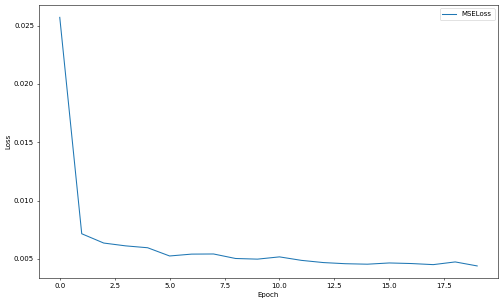

[DEBUG   17:27:36]  [Cache]  Generating cache file: .\cache\prognosis_bearing_model.pkl
[DEBUG   17:27:36]  [Cache]  Generated cache file: .\cache\prognosis_bearing_model.pkl


In [7]:
model = Cache.load('prognosis_bearing_model', cache_model)
if model is None:
    model = CNN(2048, 1, end_with_sigmoid=False)
    # 开始训练
    losses = trainer.train(model=model, train_set=train_set)
    Plotter.loss(losses)
    Cache.save(model, 'prognosis_bearing_model')

# 测试模型

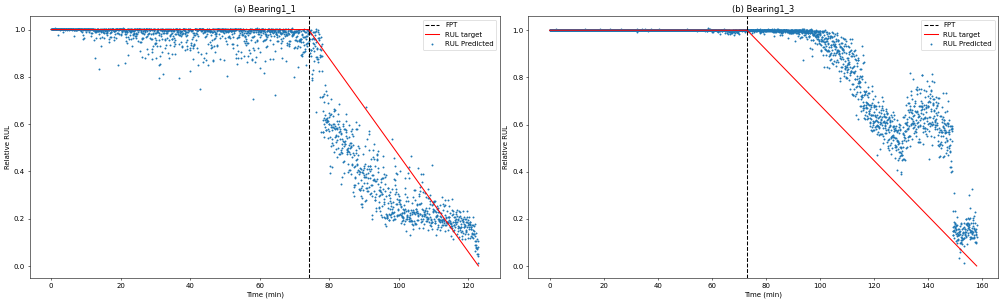

'default'

In [8]:
result = tester.test(model, test_set)
Plotter.rul_end2end(test_set, result, is_scatter=True, label_x='Time (min)', label_y='Relative RUL')

# 预测结果评价

In [9]:
evaluator = Evaluator()
evaluator.add(MAE(), MSE(), RMSE(), PercentError(), PHM2012Score(), PHM2008Score())
evaluator(test_set, result)

D:\project\UniPHM（开源）\uniphm\engine\metric\PHM2012Score.py:33: RuntimeWarning: overflow encountered in exp
  np.exp(np.log(0.5) * (percent_error / 20)))
[INFO    17:27:36]  
[Evaluator]  Performance Evaluation:
                 MAE     MSE    RMSE PercentError PHM2012Score PHM2008Score
Bearing1_1    0.0794  0.0174  0.1319        8.23%       0.6843      12.4227
Bearing1_3    0.1272  0.0382  0.1955      -17.35%       0.4833      32.6267
mean(global)  0.1062  0.0291  0.1706       -5.57%       0.5713      45.0494
mean(group)   0.1062  0.0291  0.1677       -6.15%       0.5713      23.7830



,MAE,MSE,RMSE,PercentError,PHM2012Score,PHM2008Score
Bearing1_1,0.0794,0.0174,0.1319,8.23%,0.6843,12.4227
Bearing1_3,0.1272,0.0382,0.1955,-17.35%,0.4833,32.6267
mean(global),0.1062,0.0291,0.1706,-5.57%,0.5713,45.0494
mean(group),0.1062,0.0291,0.1677,-6.15%,0.5713,23.7830
